In [81]:
#Gempy_Mesh
import gempy as gp
import gempy_viewer as gpv
import vtk
import rasterio
import pyevtk
from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz
from scipy.interpolate import LinearNDInterpolator
from SimPEG import maps, inverse_problem, regularization, optimization, inversion, data_misfit, data, utils
from SimPEG.potential_fields import gravity
from SimPEG import discretize
import SimPEG.potential_fields as pf
from gempy.core.data import GeoModel
from gempy.core.data import Grid
from gempy.core.data.grid_modules import RegularGrid
import matplotlib as mpl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, time
import pyvista as pv
from gempy_engine.core.data.stack_relation_type import StackRelationType

In [82]:
nx, ny, nz= 1, 1, 1
geo_model: gp.data.GeoModel = gp.create_geomodel(
    project_name='Model1',
    extent=[853610.2891, 855569.4948, 
            987530.5888, 988620.4712, 
            -6600, 3000], #x, y, z
    resolution=[nx, ny, nz],
    refinement=4, # We will use octrees
    importer_helper= gp.data.ImporterHelper(
        path_to_orientations= "model_fault_orientation1.csv",
        path_to_surface_points= "model_fault_points.csv",
        # path_to_orientations= "Model_Orientations.csv",
        # path_to_surface_points= "Model_Points.csv",

    )
)

In [83]:
gp.map_stack_to_surfaces(
    gempy_model=geo_model,
    mapping_object=  # TODO: This mapping I do not like it too much. We should be able to do it passing the data objects directly
    {
        "Strat_Series1": ('Complejo_Dacitico'),     
        "Strat_Series2": ('Edificio_Volcanico'),
        "Strat_Series3": ('Flujo_Piroclastico', 'Sucesion_Piroclastica', 'Sucesion_Volcanica')
    }
)
geo_model.structural_frame  # Display the resulting structural frame


StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Strat_Series1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Complejo_Dacitico,
	color=#015482,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series2,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Edificio_Volcanico,
	color=#9f0052,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series3,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Flujo_Piroclastico,
	color=#ffbe00,
	is_active=True
),
Element(
	name=Sucesion_Piroclastica,
	color=#728f02,
	is_active=True
),
Element(
	name=Sucesion_Volcanica,
	color=#443988,
	is_active=True
)
]
)
],
	fault_relations=
[[False, False, False],
 [False, False, False],
 [False, False, False]],

In [84]:
geo_model.grid

Grid(values=array([[854589.89195, 988075.53   ,  -1800.     ]]), length=array([], dtype=float64), _octree_grid=None, _dense_grid=RegularGrid(resolution=array([1, 1, 1]), extent=array([853610.2891, 855569.4948, 987530.5888, 988620.4712,  -6600.    ,
         3000.    ]), values=array([[854589.89195, 988075.53   ,  -1800.     ]]), mask_topo=array([], shape=(0, 3), dtype=bool), _transform=None), _custom_grid=None, _topography=None, _sections=None, _centered_grid=None, _transform=None, _octree_levels=-1)

In [ ]:
geo_model.solutions

: 

In [ ]:
geo_model.input_transform.apply_anisotropy(gp.data.GlobalAnisotropy.NONE)
geo_model.interpolation_options.kernel_options.range *= 3.2
# geo_model.interpolation_options.kernel_options.compute_condition_number = True
geo_model.interpolation_options.evaluation_options.evaluation_chunk_size = 500_000

gp.compute_model(
    gempy_model=geo_model,
    engine_config=gp.data.GemPyEngineConfig(
        backend=gp.data.AvailableBackends.PYTORCH
    )
)


Setting Backend To: AvailableBackends.PYTORCH
Chunking done: 6 chunks


In [ ]:
# gpv.plot_3d(model=geo_model,
#             plotter_type='basic',
#             kwargs_plot_structured_grid={'opacity': .6},
#             show_surfaces=True,
#             show_topography=True,
#             show_data=False,
#             show_lith=False,
#             image=False,
#             legend=True,
#             ve=1
#             )

In [ ]:
# datos = pd.read_excel(r"D:/cosas wis 7 semestre/SIGAC/ProyectoSGC_VCM/Datos/Datos1.xlsx")
datos = pd.read_excel(r"C:/Users/gabri/Downloads/Cosas Wis 8° semestre/SIGAC/Proyecto_ArcMap/Datos_XYZ_480.xlsx")

datos

,X,Y,Zcorregido,Z
0,853646.7891,987574.5888,-7251.142920,2248.857080
1,853711.7891,987574.5888,-7201.797764,2298.202236
2,853776.7891,987574.5888,-7168.875682,2331.124318
3,853841.7891,987574.5888,-7130.409386,2369.590614
4,853906.7891,987574.5888,-7087.584756,2412.415244
...,...,...,...,...
475,855271.7891,988564.5888,-6990.480327,2509.519673
476,855336.7891,988564.5888,-6986.546973,2513.453027
477,855401.7891,988564.5888,-6980.250222,2519.749778
478,855466.7891,988564.5888,-6969.591746,2530.408254


In [ ]:
#DEFINIR TOPOGRAFÍA
x_topo = datos["X"]
y_topo = datos["Y"]
z_topo = datos["Z"]

x_topo = x_topo.to_numpy()
y_topo = y_topo.to_numpy()
z_topo = z_topo.to_numpy()

x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)

topo_xyz = np.c_[x_topo, y_topo, z_topo]

topo_xyz

array([[853646.7891    , 987574.5888    ,   2248.85708026],
       [853711.7891    , 987574.5888    ,   2298.20223624],
       [853776.7891    , 987574.5888    ,   2331.12431765],
       ...,
       [855401.7891    , 988564.5888    ,   2519.74977784],
       [855466.7891    , 988564.5888    ,   2530.40825395],
       [855531.7891    , 988564.5888    ,   2558.30807815]])

In [ ]:
#DEFINIR EL LEVANTAMIENTO, ESTUDIO, SONDEO... (SURVEY)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo) #Interpolación de los puntos xyz
z = fun_interp(np.c_[x_topo, y_topo]) + 5.0
receiver_locations = np.c_[x_topo, y_topo, z]

components = ["gz"] # Se definen los componentes del campo que queremos simular con cadenas dentro de una lista
                    # Aqui solo se simula el componente vertical de la anomalía gravitatoria
receiver_list = gravity.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]   #Se usan las ubicaciones de observación y los componentes para definir los receptores
                                  #Para simular dichos datos, los receptores deben definirse como una lista
source_field = gravity.sources.SourceField(receiver_list=receiver_list) #Definir el campo de origen

survey = gravity.survey.Survey(source_field)   #Definir el sondeo (SURVEY)

# receiver_locations
z

array([2253.85708026, 2303.20223624, 2336.12431765, 2374.59061364,
       2417.41524418, 2465.79317108, 2500.24581345, 2530.62290023,
       2588.99737227, 2635.88593072, 2681.54459521, 2707.56713708,
       2699.57577554, 2680.76575455, 2658.28172069, 2633.32450791,
       2611.51090971, 2591.87233805, 2589.24211055, 2595.34607107,
       2576.7906175 , 2535.25047862, 2496.53585764, 2461.19348148,
       2455.95141423, 2458.27368825, 2462.78862878, 2477.03829939,
       2495.8652917 , 2537.70148097, 2253.73932856, 2304.58421738,
       2346.23321714, 2386.75975434, 2419.16022101, 2473.88878797,
       2509.99019168, 2551.73510056, 2597.22392517, 2643.13430355,
       2707.51304512, 2742.03551676, 2737.4021167 , 2713.55386195,
       2679.50447145, 2653.54072031, 2625.6579367 , 2601.85796609,
       2596.        , 2597.02177872, 2581.62215947, 2541.39829185,
       2501.8183602 , 2470.53705669, 2476.60406511, 2492.54624216,
       2491.15875686, 2486.01210729, 2493.42443423, 2510.40604

In [ ]:
# gp.set_topography_from_subsurface_structured_grid(meshes)

In [ ]:
# dx = 5
# ncx = 280
# dy = 6
# ncy = 111
# dz = 20
# ncz = 350
# dpadh = 2.7
# exp_h = 1.7

# hx = [(54, dpadh, -exp_h), (dx, ncx), (54, dpadh, exp_h)]
# hy = [(45, dpadh, -exp_h), (dy, ncy), (45, dpadh, exp_h)]
# hz = [(204, dpadh, -exp_h), (dz, ncz), (204, dpadh, exp_h)]
# meshes = TensorMesh([hx, hy, hz], x0=[853614,987543,-6000])
# cell_centers = meshes.cell_centers
# xy_ravel=cell_centers
                           
# meshes.plot_grid(color="midnightblue", linewidth=0.1)
# plt.plot(x_topo, y_topo, z_topo, '.', color='tomato')


Dimensiones de la malla: (144, 59, 179)
Número total de celdas: 1520784
Rango X: 853614.0 a 855509.7200000002
Rango Y: 987543.0 a 988616.1000000001
Rango Z: -6000.0 a 2872.72


<Figure size 1000x800 with 0 Axes>

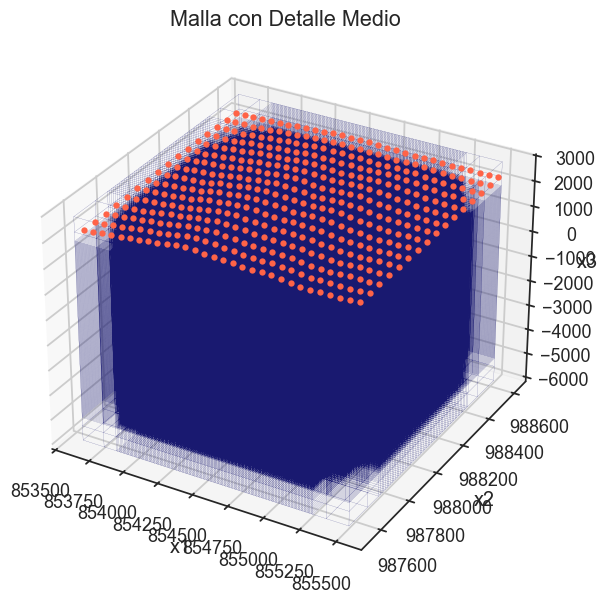

In [ ]:
# from discretize import TensorMesh
# import matplotlib.pyplot as plt

# # Valores con la mitad del detalle (celdas el doble de grandes, mitad de cantidad)
# dx = 10  # 5 × 2
# ncx = 140  # 280 ÷ 2
# dy = 12  # 6 × 2
# ncy = 55  # 111 ÷ 2 (redondeado)
# dz = 40  # 20 × 2
# ncz = 175  # 350 ÷ 2
# dpadh = 2.7  # Se mantiene igual
# exp_h = 1.7  # Se mantiene igual

# # Definir la malla con los valores ajustados
# hx = [(54, dpadh, -exp_h), (dx, ncx), (54, dpadh, exp_h)]
# hy = [(45, dpadh, -exp_h), (dy, ncy), (45, dpadh, exp_h)]
# hz = [(204, dpadh, -exp_h), (dz, ncz), (204, dpadh, exp_h)]
# meshes = TensorMesh([hx, hy, hz], x0=[853614, 987543, -6000])
# cell_centers = meshes.cell_centers
# xy_ravel = cell_centers

# # Mostrar información de la malla
# print(f"Dimensiones de la malla: {meshes.shape_cells}")
# print(f"Número total de celdas: {meshes.nC}")
# print(f"Rango X: {meshes.nodes_x[0]} a {meshes.nodes_x[-1]}")
# print(f"Rango Y: {meshes.nodes_y[0]} a {meshes.nodes_y[-1]}")
# print(f"Rango Z: {meshes.nodes_z[0]} a {meshes.nodes_z[-1]}")

# # Visualizar la malla
# plt.figure(figsize=(10, 8))
# meshes.plot_grid(color="midnightblue", linewidth=0.1)
# if 'x_topo' in globals() and 'y_topo' in globals() and 'z_topo' in globals():
#     plt.plot(x_topo, y_topo, z_topo, '.', color='tomato')
# plt.title('Malla con Detalle Medio')
# plt.show()

In [ ]:
dx = 35
ncx = 40
dy = 37
ncy = 15
dz = 200
ncz = 40
dpadh = 3.5
exp_h = 1.5

hx = [(dx, dpadh, -exp_h), (dx, ncx), (dx, dpadh, exp_h)]
hy = [(dy, dpadh, -exp_h), (dy, ncy), (dy, dpadh, exp_h)]
hz = [(dz, 3, -exp_h), (dz, ncz)]
meshes = TensorMesh([hx, hy, hz], x0=[853614,987543,-6000])
cell_centers = meshes.cell_centers
xy_ravel=cell_centers
                           
meshes.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x_topo, y_topo, z_topo, '.', color='tomato')



In [ ]:
# gpv.plot_2d(geo_model, direction='z', show=False)
# plt.scatter(xy_ravel[:, 0], xy_ravel[:, 1], s=2) #plotea las columnas X y Y del xy_ravel
# plt.show()

In [ ]:
array_sol = geo_model.solutions.raw_arrays.lith_block.reshape((1,1,1), order='F')


In [ ]:
lith_block = gp.compute_model_at(geo_model, cell_centers)

Active grids: GridTypes.NONE|CUSTOM|DENSE
Setting Backend To: AvailableBackends.numpy


MemoryError: Unable to allocate 1.19 GiB for an array with shape (107, 499225, 3) and data type float64

In [ ]:
# gpv.plot_3d(model=geo_model,
#             plotter_type='basic',
#             kwargs_plot_structured_grid={'opacity': .6},
#             show_surfaces=True,
#             show_topography=True,
#             show_data=False,
#             show_lith=False,
#             image=False,
#             legend=True,
#             # ve=0.1
#             )

In [ ]:
# Definir los valores de contraste de densidad para cada unidad en g/cm³

background_density = 2.75

densities = {
    0: background_density,  # Densidad del complejo metamórfico (g/cm³) #2.9
    1: 2.45,  # Densidad de Complejo_Dacitico                            #2.2
    2: 2.55,  # Densidad de Cuerpo_Intrusivo                             #2.4
    3: 2.6,  # Densidad de Flujo_Piroclastico                           #2.5
    4: 2.65,  # Densidad de Sucesion_Piroclastica                        #2.6
    5: 2.73  # Densidad de Sucesion_Volcanica                            #2.7
}



# Encontrar los índices para las celdas de malla activas (por ejemplo, celdas debajo de la superficie)
ind_active = active_from_xyz(meshes, topo_xyz)

# Definir el mapeo del modelo a las celdas activas
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)

# Definir el modelo. Los modelos en SimPEG son arrays vectoriales.
model = np.zeros(nC)

# Mapear los valores de contraste de densidad del modelo GemPy al modelo SimPEG
for i, density in densities.items():
    ind_lith = lith_block[ind_active] == i
    model[ind_lith] = density - background_density 





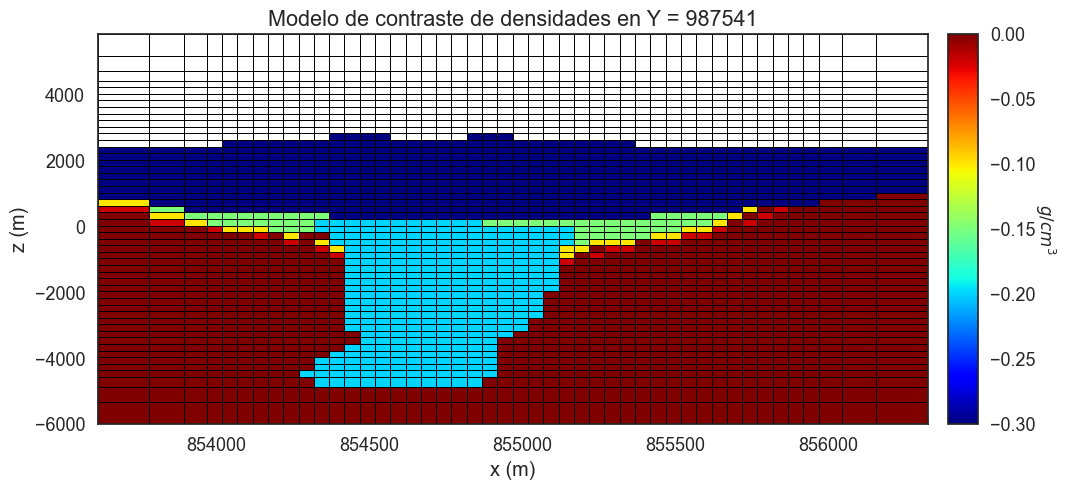

In [ ]:
# Visualizar el modelo de contraste de densidad
fig = plt.figure(figsize=(10, 5))
plotting_map = maps.InjectActiveCells(meshes, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.83, 0.78])
meshes.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(meshes.shape_cells[1] / 3),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolor_opts={"cmap": "jet"},
)
ax1.set_title("Modelo de contraste de densidades en Y = 987541")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.95, 0.12, 0.03, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

# plt.savefig('contraste_de_densidad_Y.png', dpi=300)

plt.show()

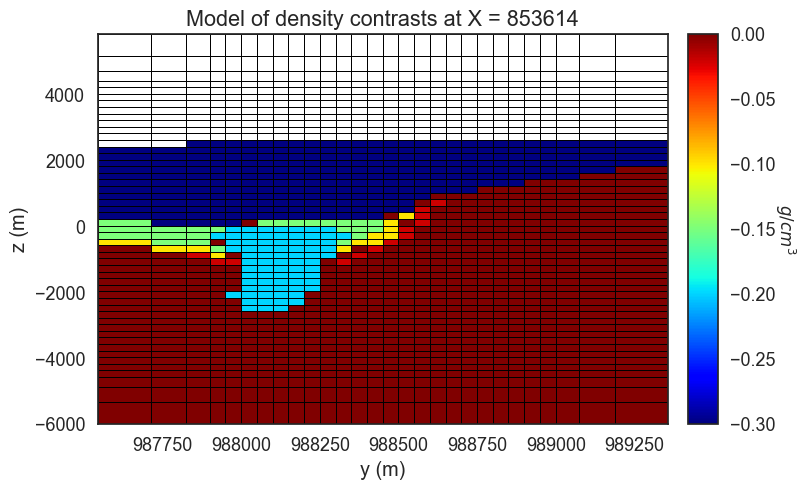

In [ ]:
# Visualizar el modelo de contraste de densidad
fig = plt.figure(figsize=(10, 5))
plotting_map = maps.InjectActiveCells(meshes, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.57, 0.78])
meshes.plot_slice(
    plotting_map * model,
    normal="X",
    ax=ax1,
    ind=int(meshes.shape_cells[2] / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolor_opts={"cmap": "jet"},
)
ax1.set_title("Model of density contrasts at X = 853614")
ax1.set_xlabel("y (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.69, 0.12, 0.03, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

# plt.savefig('contraste_de_densidad_X.png', dpi=300)

plt.show()

In [ ]:
# Configurar el survey (asumiendo que ya lo tienes definido como en tu código anterior)
# survey = gravity.survey.Survey(source_field)

# Crear el problema de gravedad
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=meshes,
    rhoMap=model_map,
    ind_active=ind_active,
    store_sensitivities="forward_only",
    engine="geoana",
)


# Realizar la simulación directa
d_pred = simulation.dpred(model)


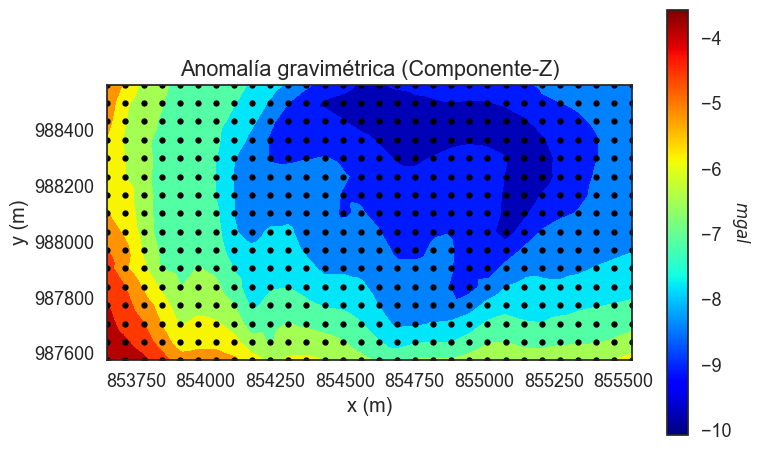

In [ ]:
# Plot
from SimPEG.utils import plot2Ddata, model_builder
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(receiver_list[0].locations, -d_pred, ax=ax1, contourOpts={"cmap": "jet"})
ax1.set_title("Anomalía gravimétrica (Componente-Z)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")


plt.plot(x_topo, y_topo, '.', color='black', )

ax2 = fig.add_axes([0.90, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(d_pred)), vmax=np.max(-d_pred))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap="jet", #format="%.0e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()


c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\simpeg\potential_fields\gravity\simulation.py:267: RuntimeWarning: invalid value encountered in prism_fz
  node_evals["gz"] = prism_fz(dx, dy, dz)


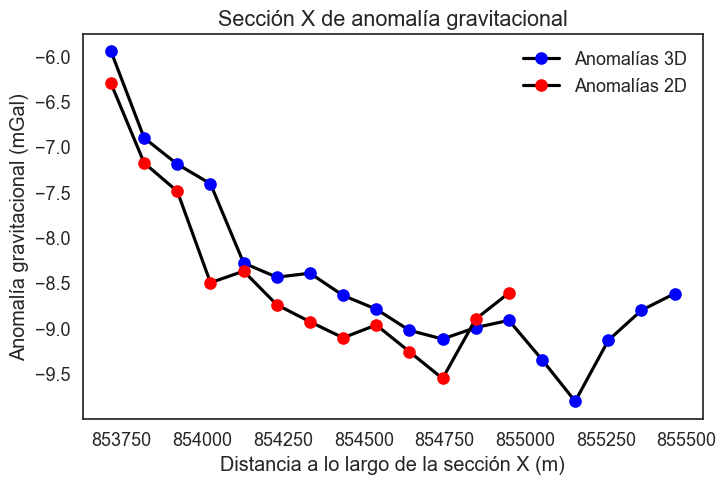

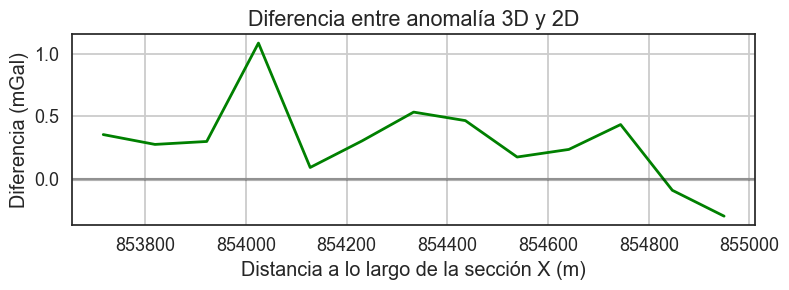

In [ ]:
# Asumiendo que tienes tus datos 3D en una variable llamada 'd_pred'
# y las coordenadas x, y, z correspondientes

# Definir la línea de sección (ajusta estos valores según tu necesidad)
x_start, y_start = 853614, 988169  # Coordenadas de inicio
x_end, y_end = 855566, 988169  # Coordenadas de fin

# Crear puntos a lo largo de la línea de sección
num_points = 20
x_section = np.linspace(x_start, x_end, num_points)
y_section = np.linspace(y_start, y_end, num_points)

# Interpolar los valores de anomalía gravitacional a lo largo de la sección
from scipy.interpolate import griddata

points = np.column_stack((receiver_locations[:, 0], receiver_locations[:, 1]))
values = -d_pred
xi = np.column_stack((x_section, y_section))
z_section = griddata(points, values, xi, method='linear')

# Calcular la distancia a lo largo de la sección
distance = np.sqrt((x_section - x_start)**2 + (y_section - y_start)**2) + 853614

# Para la visualización (comentado)
X, Y = np.meshgrid(distance, np.linspace(z_section.min(), z_section.max(), num_points))
Z = np.tile(z_section, (num_points, 1))
# im = plt.pcolormesh(X, Y, Z, shading='auto', cmap='jet')

# Definir la sección 2D
y_section_2d = 988169  # El valor Y de tu sección

# Crear una línea de receptores a lo largo de la sección (en X)
x_range = np.linspace(meshes.x0[0], meshes.x0[0] + meshes.h[0].sum(), 20)
y_range = np.full_like(x_range, y_section_2d)
z_topo = fun_interp(np.c_[x_range, y_range])
receiver_locations_2d = np.c_[x_range, y_range, z_topo + 5.0]

# Crear nuevos receptores y survey para la sección 2D
receiver_list_2d = gravity.receivers.Point(receiver_locations_2d, components=["gz"])
source_field_2d = gravity.sources.SourceField(receiver_list=[receiver_list_2d])
survey_2d = gravity.survey.Survey(source_field_2d)

# Calcular las anomalías gravimétricas para la sección 2D
simulation_2d = gravity.simulation.Simulation3DIntegral(
    survey=survey_2d,
    mesh=meshes,
    rhoMap=maps.IdentityMap(nP=model.size),
    ind_active=ind_active,
)
d_pred_2d = simulation_2d.dpred(model)

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(distance, (z_section), color='black', marker="o", markerfacecolor='blue', label="Anomalías 3D")
plt.plot(distance, (-d_pred_2d), color='black', marker="o", markerfacecolor='red', label="Anomalías 2D")
plt.xlabel('Distancia a lo largo de la sección X (m)')
plt.ylabel('Anomalía gravitacional (mGal)')
plt.title('Sección X de anomalía gravitacional')
plt.legend()
# plt.colorbar(im, label='mGal')
plt.show()

# Calcular y mostrar la diferencia entre ambas respuestas
diff = z_section - (-d_pred_2d)
plt.figure(figsize=(8, 3))
plt.plot(distance, diff, 'g-', linewidth=2)
plt.xlabel('Distancia a lo largo de la sección X (m)')
plt.ylabel('Diferencia (mGal)')
plt.title('Diferencia entre anomalía 3D y 2D')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

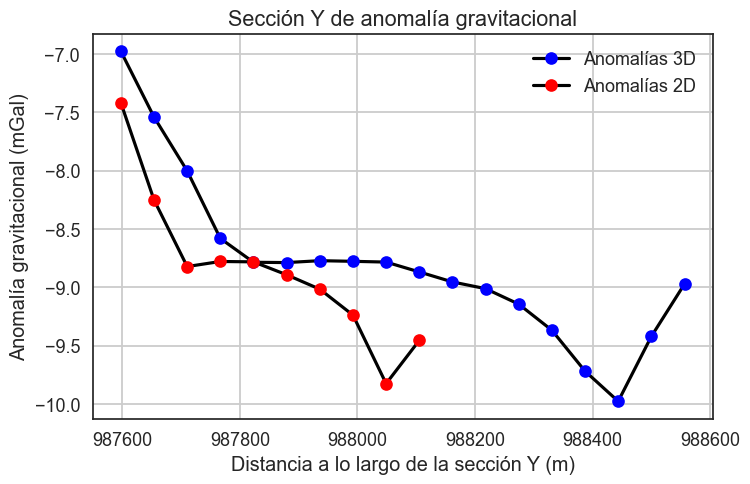

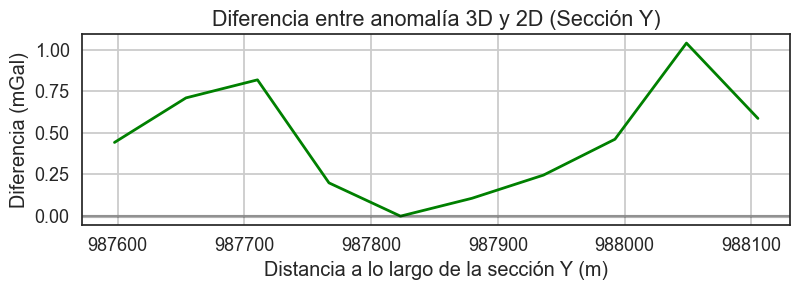

In [ ]:
# Definir la línea de sección (sección Y)
x_start, y_start = 854892, 987541  # Coordenadas de inicio
x_end, y_end = 854892, 988613  # Coordenadas de fin

# Crear puntos a lo largo de la línea de sección
num_points = 20
x_section = np.linspace(x_start, x_end, num_points)
y_section = np.linspace(y_start, y_end, num_points)

# Interpolar los valores de anomalía gravitacional a lo largo de la sección
from scipy.interpolate import griddata

points = np.column_stack((receiver_locations[:, 0], receiver_locations[:, 1]))
values = -d_pred
xi = np.column_stack((x_section, y_section))
z_section = griddata(points, values, xi, method='linear')

# Calcular la distancia a lo largo de la sección
distance = np.sqrt((x_section - x_start)**2 + (y_section - y_start)**2) + 987541

# Para la visualización (comentado)
X, Y = np.meshgrid(distance, np.linspace(z_section.min(), z_section.max(), num_points))
Z = np.tile(z_section, (num_points, 1))
# im = plt.pcolormesh(X, Y, Z, shading='auto', cmap='jet')

# Definir la sección 2D
x_section_2d = 854892  # El valor X fijo para la sección

# Crear una línea de receptores a lo largo de la sección (en Y)
y_range = np.linspace(meshes.x0[1], meshes.x0[1] + meshes.h[1].sum(), 20)
x_range = np.full_like(y_range, x_section_2d)
z_topo = fun_interp(np.c_[x_range, y_range])
receiver_locations_2d = np.c_[x_range, y_range, z_topo + 5.0]

# Crear nuevos receptores y survey para la sección 2D
receiver_list_2d = gravity.receivers.Point(receiver_locations_2d, components=["gz"])
source_field_2d = gravity.sources.SourceField(receiver_list=[receiver_list_2d])
survey_2d = gravity.survey.Survey(source_field_2d)

# Calcular las anomalías gravimétricas para la sección 2D
simulation_2d = gravity.simulation.Simulation3DIntegral(
    survey=survey_2d,
    mesh=meshes,
    rhoMap=maps.IdentityMap(nP=model.size),
    ind_active=ind_active,
)
d_pred_2d = simulation_2d.dpred(model)

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(distance, (z_section), color='black', marker="o", markerfacecolor='blue', label="Anomalías 3D")
plt.plot(distance, (-d_pred_2d), color='black', marker="o", markerfacecolor='red', label="Anomalías 2D")
plt.xlabel('Distancia a lo largo de la sección Y (m)')
plt.ylabel('Anomalía gravitacional (mGal)')
plt.title('Sección Y de anomalía gravitacional')
plt.legend()
plt.grid(True)
# plt.savefig('comparacion_anomalia_2D_vs_3D_seccion_Y.png', dpi=300)
plt.show()

# Calcular y mostrar la diferencia entre ambas respuestas
diff = z_section - (-d_pred_2d)
plt.figure(figsize=(8, 3))
plt.plot(distance, diff, 'g-', linewidth=2)
plt.xlabel('Distancia a lo largo de la sección Y (m)')
plt.ylabel('Diferencia (mGal)')
plt.title('Diferencia entre anomalía 3D y 2D (Sección Y)')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
# plt.savefig('diferencia_anomalia_2D_vs_3D_seccion_Y.png', dpi=300)
plt.show()



In [ ]:
print("Longitud de x_topo:", len(x_topo))
print("Longitud de y_topo:", len(y_topo))
print("Longitud de z_topo:", len(z_topo))
print("Longitud de d_pred:", len(d_pred))

Longitud de x_topo: 480
Longitud de y_topo: 480
Longitud de z_topo: 20
Longitud de d_pred: 480


In [ ]:
# Set this to True to save the output
save_output = True

if save_output:
    # Get the current working directory (this should be your JupyterLab working directory)
    current_dir = os.getcwd()
    
    # Create an 'outputs' folder in the current directory if it doesn't exist
    output_dir = os.path.join(current_dir, "outputs")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save topography data
    topo_filename = os.path.join(output_dir, "gravity_topo_480.txt")
    np.savetxt(topo_filename, topo_xyz, fmt="%.4e")
    print(f"Topography data saved to {topo_filename}")

    # Save receiver locations and gravity data
    np.random.seed(737)
    maximum_anomaly = np.max(np.abs(-d_pred))
    noise = 0.1 * maximum_anomaly * np.random.randn(len(d_pred))
    gravity_filename = os.path.join(output_dir, "gravity_data_480_e01.txt")
    np.savetxt(gravity_filename, np.column_stack((receiver_locations, -d_pred + noise)), fmt="%.4e")
    print(f"Gravity data saved to {gravity_filename}")

# Display the full path of the saved files
print(f"\nFiles are saved in the following directory:\n{output_dir}")

Topography data saved to c:\Users\gabri\Downloads\Cosas Wis 9° semestre\SIGAC\VCM_Project\Proyecto_VCM_CodigoPython_gempyXsimpeg\Inversion&Modelamiento_VCM\Modelamiento_directo\outputs\gravity_topo_480.txt
Gravity data saved to c:\Users\gabri\Downloads\Cosas Wis 9° semestre\SIGAC\VCM_Project\Proyecto_VCM_CodigoPython_gempyXsimpeg\Inversion&Modelamiento_VCM\Modelamiento_directo\outputs\gravity_data_480_e01.txt

Files are saved in the following directory:
c:\Users\gabri\Downloads\Cosas Wis 9° semestre\SIGAC\VCM_Project\Proyecto_VCM_CodigoPython_gempyXsimpeg\Inversion&Modelamiento_VCM\Modelamiento_directo\outputs


In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import os

# Asumiendo que tienes:
# receiver_locations: array con las coordenadas x, y de los receptores
# d_pred: array con los valores de anomalía gravitacional predichos

# Primero, vamos a crear una cuadrícula regular de 400 puntos
num_points = 400
x_min, x_max = np.min(receiver_locations[:, 0]), np.max(receiver_locations[:, 0])
y_min, y_max = np.min(receiver_locations[:, 1]), np.max(receiver_locations[:, 1])
z_min, z_max = np.min(receiver_locations[:, 2]), np.max(receiver_locations[:, 2])

x = np.linspace(x_min, x_max, int(np.sqrt(num_points)))
y = np.linspace(y_min, y_max, int(np.sqrt(num_points)))
z = np.linspace(z_min, z_max, int(np.sqrt(num_points)))
xx, yy, zz = np.meshgrid(x, y, z)

# Aplanar las coordenadas x e y
points = np.column_stack((xx.flatten(), yy.flatten(), zz.flatten()))

# Agregar ruido# Interpolar los valores de anomalía gravitacional en estos puntos
values = griddata(receiver_locations[:, :3], -d_pred, points, method='linear')

np.random.seed(737)
maximum_anomaly = np.max(np.abs(d_pred))
noise =  0.01 * maximum_anomaly * np.random.randn(len(values))
noisy_val=values + noise



# Crear un DataFrame con los resultados
df = pd.DataFrame({
    'X': points[:, 0],
    'Y': points[:, 1],
    'Z': points[:, 2],
    'Anomaly': noisy_val
})

# Eliminar filas con valores NaN (si los hay)
df = df.dropna()

# Si hay más de 120 puntos, seleccionar aleatoriamente 120
if len(df) > 1200:
    df = df.sample(n=1000, random_state=42)  # random_state para reproducibilidad

# Guardar en un archivo CSV
df.to_csv('gravity_anomaly_120points.csv', index=False)
print("Datos exportados a 'gravity_anomaly_120points.csv'")

# Mostrar las primeras filas para verificar
print(df.head())

Datos exportados a 'gravity_anomaly_120points.csv'
                  X              Y            Z   Anomaly
5789  854539.683837  988304.062484  2505.933415 -8.004319
7370  854440.473311  988512.483537  2533.954981 -8.199818
5149  855333.368047  988199.851958  2505.933415 -8.521346
1356  854341.262784  987730.904589  2702.084372 -7.178735
7286  854043.631205  988512.483537  2421.868720 -7.157104


In [ ]:
print("Tamaño del modelo:", model.size)
print("Dimensiones de la malla:", meshes.shape_cells)
print("Producto de las dimensiones de la malla:", np.prod(meshes.shape_cells))

Tamaño del modelo: 49847
Dimensiones de la malla: (46, 28, 51)
Producto de las dimensiones de la malla: 65688


In [ ]:
import vtk
from vtk.util import numpy_support
import numpy as np


# Crear un grid VTK
grid = vtk.vtkStructuredGrid()
grid.SetDimensions(meshes.shape_cells[0], meshes.shape_cells[1], meshes.shape_cells[2])

# Configurar los puntos
points = vtk.vtkPoints()
for i in range(meshes.nC):
    points.InsertNextPoint(meshes.gridCC[i])
grid.SetPoints(points)

# Añadir los datos del modelo
vtkArray = numpy_support.numpy_to_vtk(num_array=model.ravel(), deep=True, array_type=vtk.VTK_FLOAT)
vtkArray.SetName("density_contrast")
grid.GetPointData().AddArray(vtkArray)

# Escribir el archivo
writer = vtk.vtkXMLStructuredGridWriter()
writer.SetFileName("modelo_simepg.vts")
writer.SetInputData(grid)
writer.Write()

print("Modelo exportado a 'modelo_simepg.vts'")

ERROR:root:Point array density_contrast with 1 components, only has 49847 tuples but there are 65688 points
ERROR:root:Input is invalid for piece 0.  Aborting.
ERROR:root:Algorithm vtkXMLStructuredGridWriter (000001D4618ADA60) returned failure for request: vtkInformation (000001D4254D8150)


Modelo exportado a 'modelo_simepg.vts'


In [ ]:
models = {'density constrast':plotting_map*model}
databse = meshes.to_vtk(models)

In [ ]:
databse.save('modelo_simpeg.vtk')

In [ ]:
# import numpy as np
# import os

# # Creamos un diccionario con toda la información relevante
# modelo_datos = {
#     'grilla': {
#         'dimensiones': meshes.shape_cells,  # [nx, ny, nz]
#         'origen': meshes.x0,                # Origen de la malla [x0, y0, z0]
#         'tamaño_celdas': {
#             'h_x': meshes.h[0],             # Tamaño de celdas en dirección x
#             'h_y': meshes.h[1],             # Tamaño de celdas en dirección y
#             'h_z': meshes.h[2]              # Tamaño de celdas en dirección z
#         }
#     },
#     'modelo': {
#         'contraste_densidad': model,         # Vector de contraste de densidad
#         'celdas_activas': ind_active,        # Máscara booleana de celdas activas
#         'densidad_background': background_density  # Densidad de referencia
#     },
#     'topografia': {
#         'x': x_topo,                         # Coordenadas x de la topografía
#         'y': y_topo,                         # Coordenadas y de la topografía
#         'z': z_topo                          # Elevación de la topografía
#     },
#     'survey': {
#         'ubicaciones': receiver_locations,   # Ubicaciones de los receptores
#         'anomalia_calculada': -d_pred        # Valores de anomalía calculados
#     },
#     'parametros': {
#         'densidades': densities              # Diccionario de densidades por litología
#     }
# }

# # Reconstruir el modelo 3D completo (para visualización)
# # Creando un array lleno de ceros del tamaño de la malla
# modelo_3d = np.zeros(meshes.nC)

# # Asignar los valores de contraste solo a las celdas activas
# modelo_3d[ind_active] = model

# # Remodelar el array 1D a 3D para visualización
# modelo_3d_reshape = modelo_3d.reshape(meshes.shape_cells, order='F')

# # Añadir al diccionario
# modelo_datos['modelo']['contraste_densidad_3d'] = modelo_3d_reshape

# # Crear directorio si no existe
# output_dir = "./outputs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Guardar el diccionario completo
# np.save(os.path.join(output_dir, 'modelo_gravedad_completo.npy'), modelo_datos)

# # También guardar componentes individuales para facilitar acceso
# np.save(os.path.join(output_dir, 'modelo_contraste_densidad_3d.npy'), modelo_3d_reshape)
# np.save(os.path.join(output_dir, 'celdas_activas.npy'), ind_active)
# np.save(os.path.join(output_dir, 'receptor_locations.npy'), receiver_locations)
# np.save(os.path.join(output_dir, 'anomalia_calculada.npy'), -d_pred)

# print("Modelo guardado en:", os.path.join(output_dir, 'modelo_gravedad_completo.npy'))
# print("Componentes individuales guardados en:", output_dir)

# # Código para cargar el modelo (incluido como referencia)
# """
# # Para cargar el modelo completo:
# modelo_cargado = np.load('outputs/modelo_gravedad_completo.npy', allow_pickle=True).item()

# # Acceder a componentes:
# grilla = modelo_cargado['grilla']
# contraste_densidad = modelo_cargado['modelo']['contraste_densidad']
# modelo_3d = modelo_cargado['modelo']['contraste_densidad_3d']
# celdas_activas = modelo_cargado['modelo']['celdas_activas']

# # Para cargar componentes individuales:
# modelo_3d = np.load('outputs/modelo_contraste_densidad_3d.npy')
# celdas_activas = np.load('outputs/celdas_activas.npy')
# """

In [ ]:
import numpy as np
import os

# Creamos un único diccionario con la malla y el modelo
modelo_completo = {
    'mesh': meshes,                        # Objeto malla completo
    'model': model,                        # Vector de contraste de densidad
    'active_cells': ind_active             # Máscara booleana de celdas activas
}

# Crear directorio si no existe
output_dir = "./outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Guardar todo en un único archivo .npy
file_path = os.path.join(output_dir, 'modelo_gravedad_completo.npy')
np.save(file_path, modelo_completo)

print(f"Modelo guardado en: {file_path}")

# Verificación - Cargar el archivo y mostrar su contenido
modelo_cargado = np.load(file_path, allow_pickle=True).item()
print("\nContenido del archivo guardado:")
for key in modelo_cargado:
    if key == 'model' or key == 'active_cells':
        print(f"{key}: Array de forma {modelo_cargado[key].shape}")
    elif key == 'mesh':
        print(f"{key}: Objeto TensorMesh con forma {modelo_cargado[key].shape_cells}")
    else:
        print(f"{key}: {modelo_cargado[key]}")

# Ejemplo de reconstrucción del modelo 3D
def reconstruir_modelo_3d(modelo_datos):
    """Reconstruye el modelo 3D a partir de los datos guardados"""
    # Obtener dimensiones
    nx, ny, nz = modelo_datos['mesh'].shape_cells
    
    # Reconstruir malla completa
    modelo_3d = np.zeros((nx * ny * nz))
    
    # Asignar valores solo a celdas activas
    modelo_3d[modelo_datos['active_cells']] = modelo_datos['model']
    
    # Reshape a 3D
    return modelo_3d.reshape((nx, ny, nz), order='F')

# Reconstruir y verificar
modelo_3d = reconstruir_modelo_3d(modelo_cargado)
print(f"\nModelo 3D reconstruido con forma: {modelo_3d.shape}")

Modelo guardado en: ./outputs\modelo_gravedad_completo.npy

Contenido del archivo guardado:
mesh: Objeto TensorMesh con forma (46, 21, 43)
model: Array de forma (37539,)
active_cells: Array de forma (41538,)

Modelo 3D reconstruido con forma: (46, 21, 43)


In [ ]:
import numpy as np
import os
from discretize import TensorMesh

# Cargar el modelo guardado
file_path = "./outputs/modelo_gravedad_completo.npy"
modelo_datos = np.load(file_path, allow_pickle=True).item()

# Extraer los componentes
mesh = modelo_datos['mesh']
model = modelo_datos['model']
active_cells = modelo_datos['active_cells']

# Reconstruir modelo 3D
nx, ny, nz = mesh.shape_cells
modelo_3d = np.zeros(mesh.nC)
modelo_3d[active_cells] = model
modelo_3d_reshape = modelo_3d.reshape(nx, ny, nz, order='F')

# Obtener coordenadas de los centros de celda
cell_centers = mesh.cell_centers

# Crear directorio para archivos de salida
output_dir = "./outputs_for_oasis"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Guardar como archivo de texto (formato que Oasis Montaj puede importar)
# Formato: X Y Z Density
txt_file = os.path.join(output_dir, "modelo_densidad_para_oasis.txt")

# Filtrar solo las celdas activas y guardar
with open(txt_file, 'w') as f:
    # Escribir encabezado
    f.write("X Y Z Density\n")
    
    # Escribir datos solo de celdas activas
    for i in range(len(active_cells)):
        if active_cells[i]:
            x, y, z = cell_centers[i]
            density = modelo_3d[i]
            f.write(f"{x:.6f} {y:.6f} {z:.6f} {density:.6f}\n")

# También crear un archivo de metadatos con información de la malla
with open(os.path.join(output_dir, "metadata.txt"), "w") as f:
    f.write(f"Grid dimensions: {nx} x {ny} x {nz}\n")
    f.write(f"Origin: {mesh.x0}\n")
    f.write(f"Cell sizes: dx={mesh.h[0][0]}, dy={mesh.h[1][0]}, dz={mesh.h[2][0]}\n")
    f.write(f"Total cells: {mesh.nC}\n")
    f.write(f"Active cells: {np.sum(active_cells)}\n")

# Para Oasis Montaj, también es útil guardar como una lista de voxels
# Formato: x_min x_max y_min y_max z_min z_max density
voxel_file = os.path.join(output_dir, "modelo_voxels.txt")

# Obtener nodos de la malla
nodes_x = mesh.nodes_x
nodes_y = mesh.nodes_y
nodes_z = mesh.nodes_z

# Guardar archivo de voxels
with open(voxel_file, 'w') as f:
    # Escribir encabezado
    f.write("x_min x_max y_min y_max z_min z_max density\n")
    
    # Escribir datos de voxels
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if modelo_3d_reshape[i, j, k] != 0:  # Solo incluir celdas con valores distintos de cero
                    x_min, x_max = nodes_x[i], nodes_x[i+1]
                    y_min, y_max = nodes_y[j], nodes_y[j+1]
                    z_min, z_max = nodes_z[k], nodes_z[k+1]
                    density = modelo_3d_reshape[i, j, k]
                    f.write(f"{x_min:.6f} {x_max:.6f} {y_min:.6f} {y_max:.6f} {z_min:.6f} {z_max:.6f} {density:.6f}\n")

print(f"Archivos creados en: {output_dir}")
print(f"1. Archivo de puntos: {txt_file}")
print(f"2. Archivo de voxels: {voxel_file}")
print(f"3. Metadatos: {os.path.join(output_dir, 'metadata.txt')}")

Archivos creados en: ./outputs_for_oasis
1. Archivo de puntos: ./outputs_for_oasis\modelo_densidad_para_oasis.txt
2. Archivo de voxels: ./outputs_for_oasis\modelo_voxels.txt
3. Metadatos: ./outputs_for_oasis\metadata.txt
